# Extraction of model metrics

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import yaml

from kvae.model.model import KVAE
from kvae.utils.config import KVAEConfig
from kvae.train.utils import parse_device, build_dataloaders

## Function definitions

Model & Data Loading functions

In [2]:
def load_checkpoint(checkpoint_path, device='auto', kvae_kwargs=None):
    """
    Load a trained KVAE model from checkpoint.
    
    Args:
        checkpoint_path: Path to checkpoint file (.pt)
        device: Device to load model on ('auto', 'cuda', 'cpu', 'mps')
    
    Returns:
        model: Loaded KVAE model
        checkpoint: Full checkpoint dictionary with training info
        device: The actual device being used
    """
    checkpoint_path = Path(checkpoint_path)
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    
    device = parse_device(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Initialize model with config
    kwargs = kvae_kwargs if kvae_kwargs is not None else {}
    cfg = KVAEConfig(**kwargs)
    model = KVAE(cfg).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state'])
    model.eval()
    
    print(f"✓ Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"  Train loss: {checkpoint['train_loss']:.6f}")
    print(f"  Val loss: {checkpoint['val_loss']:.6f}")
    
    return model, checkpoint, device


def load_model_val_loader(checkpoint_path, config_path=None, device='cpu', kvae_kwargs=None):
    # Load config from the run directory
    if config_path is None:
        config_path = Path(checkpoint_path).parent.parent / "config.yaml"

    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    kvae_config = config.get('kvae', {})
    if kvae_kwargs is not None:
        kvae_config.update(kvae_kwargs)
    
    # Load model
    model, _, device = load_checkpoint(checkpoint_path, device=device, kvae_kwargs=kvae_config)

    # Load data
    _, val_loader = build_dataloaders(
        config['dataset'], 
        batch_size=config['training']['batch_size']
    )

    return model, val_loader, device

Functions for evaluation

In [3]:
def fraction_of_incorrect_pixels(y_true, y_pred):
    """
    Compute the fraction of incorrect pixels between two binary images.
    Args:
        y_true: Ground truth binary image (numpy array or torch tensor)
        y_pred: Predicted binary image (numpy array or torch tensor)
    Returns:
        Fraction of incorrect pixels (float)
    """
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy() > 0.5
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy() > 0.5
    
    incorrect_pixels = np.sum(y_true != y_pred)
    total_pixels = y_true.size
    
    return incorrect_pixels / total_pixels if total_pixels > 0 else 0.0
metrics_functions = {
    "fraction_of_incorrect_pixels": fraction_of_incorrect_pixels,
}


def fraction_of_incorrect_pixels(y_true, y_pred):
    """
    Compute the fraction of incorrect pixels between two binary images.
    Args:
        y_true: Ground truth binary image (numpy array or torch tensor)
        y_pred: Predicted binary image (numpy array or torch tensor)
    Returns:
        Fraction of incorrect pixels (float)
    """
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy() > 0.5
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy() > 0.5
    
    incorrect_pixels = np.sum(y_true != y_pred)
    total_pixels = y_true.size
    
    return incorrect_pixels / total_pixels if total_pixels > 0 else 0.0


def evaluate_impute_metrics(model, loader, device, metrics_function, mask_sampling_fn, output_keys):
    model.eval()
    n_batches  = 0

    total_metrics = {key: 0.0 for key in output_keys}
    for batch in tqdm(loader, desc="Evaluating:"):
        model.kalman_filter.dyn_params.reset_state()

        x = batch["images"].float()
        B, T = x.shape[:2]

        mask = mask_sampling_fn(B, T)
        
        with torch.no_grad():
            outputs = model.impute(x.to(device), mask.to(device))

            for out_key in output_keys:
                total_metrics[out_key] += metrics_function(x.detach(), outputs[out_key].detach())
            
            # Explicit cleanup
            del outputs, x, mask
        
        n_batches += 1

    denom = max(n_batches, 1)
    mean_metrics = {k: v / denom for k, v in total_metrics.items()}

    return mean_metrics


def get_model_metrics(model, val_loader, device, dropout_rates, metrics_function, output_keys):
    data = {'dropout_rate': dropout_rates.numpy()}
    data.update({out_key: np.zeros_like(dropout_rates.numpy()) for out_key in output_keys})

    for i, drop_rate in enumerate(dropout_rates):
        drop_rate_val = float(drop_rate)  # Capture value, not reference
        dropout_mask_sampling = lambda B, T, dr=drop_rate_val: (torch.rand(B, T, device=device) < (1 - dr)).float()
        outs = evaluate_impute_metrics(model, val_loader, device, metrics_function, dropout_mask_sampling, output_keys)
        for out_key, metric_value in outs.items():
            data[out_key][i] = metric_value

    return pd.DataFrame(data)

## Visualization and comparison

In [4]:
runs_path = Path("../runs/20251213-131228")
checkpoint_path = runs_path / "checkpoints/kvae-best.pt"


model, val_loader, device = load_model_val_loader(checkpoint_path, device='cpu', kvae_kwargs={'dynamics_model': 'lstm'})
metrics_function = fraction_of_incorrect_pixels
output_keys = [
    "x_recon",
    "x_filtered",
    "x_imputed",
]
dropout_rates = torch.linspace(0.2, 1.0, steps=5)

df_original = get_model_metrics(model, val_loader, device, dropout_rates, metrics_function, output_keys)

✓ Loaded checkpoint from epoch 100
  Train loss: 4.088638
  Val loss: 4.011723


Evaluating::   0%|          | 0/32 [00:00<?, ?it/s]/Users/rodrigopaganini/master/code/pgm/kalman-vae/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating:: 100%|██████████| 32/32 [00:46<00:00,  1.44s/it]


In [5]:
runs_path = Path("../runs/skvae-20251215-234708")
checkpoint_path = runs_path / "checkpoints/kvae-best.pt"

model, val_loader, device = load_model_val_loader(checkpoint_path, config_path=runs_path / "config_MODIFIED.yaml", device='cpu')
metrics_function = fraction_of_incorrect_pixels
output_keys = [
    "x_recon",
    "x_filtered",
    "x_imputed",
]
dropout_rates = torch.linspace(0.2, 1.0, steps=5)

df_skvae = get_model_metrics(model, val_loader, device, dropout_rates, metrics_function, output_keys)

✓ Loaded checkpoint from epoch 89
  Train loss: 4.873523
  Val loss: 4.959289


Evaluating:: 100%|██████████| 32/32 [00:42<00:00,  1.34s/it]


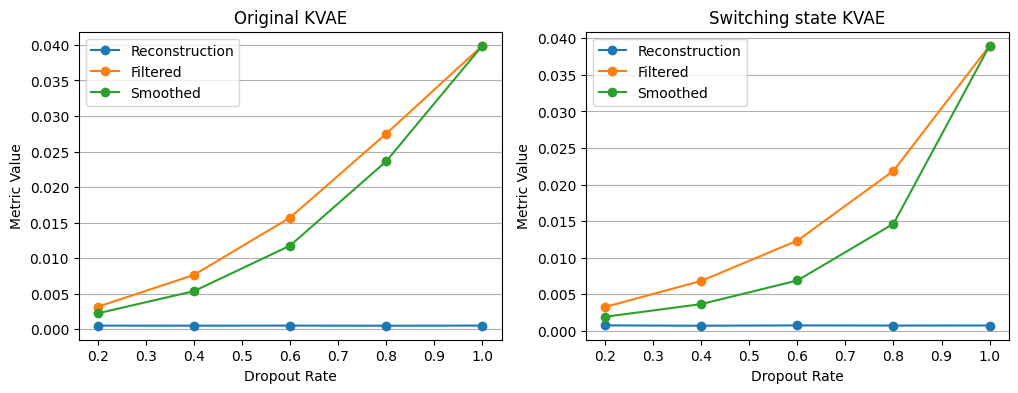

In [6]:
plot_columns = {
    'Reconstruction': 'x_recon',
    'Filtered': 'x_filtered',
    'Smoothed': 'x_imputed',
}

fig, axs = plt.subplots(1,2, figsize=(12, 4))

for col in plot_columns.keys():
    values = df_original[plot_columns[col]].values
    axs[0].plot(dropout_rates.numpy(), values, marker='o', label=col)
axs[0].set_xlabel("Dropout Rate")
axs[0].set_ylabel("Metric Value")
axs[0].set_title("Original KVAE")
axs[0].legend()
axs[0].grid(axis='y')

for col in plot_columns.keys():
    values = df_skvae[plot_columns[col]].values
    axs[1].plot(dropout_rates.numpy(), values, marker='o', label=col)
axs[1].set_xlabel("Dropout Rate")
axs[1].set_ylabel("Metric Value")
axs[1].set_title("Switching state KVAE")
axs[1].legend()
axs[1].grid(axis='y')

plt.show()



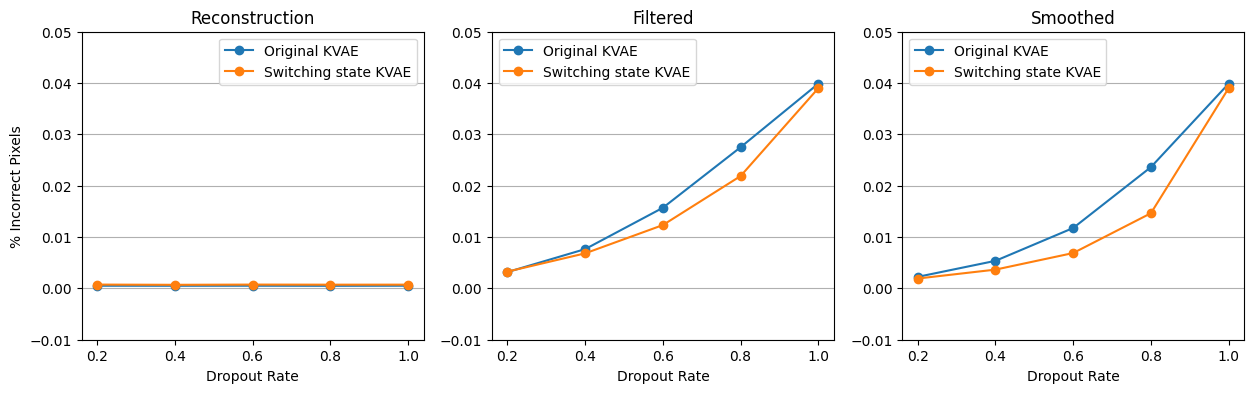

In [7]:
plot_columns = {
    'Reconstruction': 'x_recon',
    'Filtered': 'x_filtered',
    'Smoothed': 'x_imputed',
}

fig, axs = plt.subplots(1, len(plot_columns), figsize=(15, 4))

for ax, col in zip(axs.flatten(), plot_columns.keys()):
    values = df_original[plot_columns[col]].values
    ax.plot(dropout_rates.numpy(), values, marker='o', label='Original KVAE')
    values = df_skvae[plot_columns[col]].values
    ax.plot(dropout_rates.numpy(), values, marker='o', label='Switching state KVAE')
    
    ax.set_xlabel("Dropout Rate")
    ax.set_title(col)
    ax.legend()
    ax.grid(axis='y')
    ax.set_ylim(-0.01, 0.05)

axs[0].set_ylabel("% Incorrect Pixels")
plt.show()
